In [1]:
import scanpy as sc
import surgeon

Using TensorFlow backend.


In [2]:
sc.settings.set_figure_params(dpi=200)

In [3]:
condition_key = "study"
cell_type_key = 'cell_type'
target_conditions = ["Pancreas Celseq", "Pancreas CelSeq2"]

# Loading four Toy datasets and data preparation

In [4]:
adata = sc.read("./data/pancreas/pancreas_count.h5ad")
adata

AnnData object with n_obs × n_vars = 15921 × 15369 
    obs: 'batch', 'study', 'cell_type'

## Number of cells in each batch

In [5]:
adata.obs[condition_key].value_counts()

Pancreas inDrop         8569
Pancreas SS2            2989
Pancreas CelSeq2        2449
Pancreas Celseq         1276
Pancreas Fluidigm C1     638
Name: study, dtype: int64

## Now we leave out one study (SS2) for training the newtork

In [6]:
adata = surgeon.utils.normalize(adata, 
                                  filter_min_counts=False, 
                                  normalize_input=False, 
                                  size_factors=True,
                                  logtrans_input=True,
                                  n_top_genes=2000,
                                 )

## Train/Test Split

In [7]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata, 0.85)

In [8]:
train_adata.shape, valid_adata.shape

((13532, 2000), (2389, 2000))

In [9]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())
n_labels = len(train_adata.obs[cell_type_key].unique().tolist())

# Create & Train model with training data

In [10]:
network = surgeon.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=20,
                             n_conditions=n_conditions,
                             lr=0.001,
                             alpha=0.001,
                             eta=1.0,
                             clip_value=5.0,
                             model_path="./models/CVAE/Pancreas/",
                             dropout_rate=0.2,
                             )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 5)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 2005)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
_____________________

In [11]:
network.restore_model()

Model has been successfully restored!


In [12]:
classifier = surgeon.archs.NNClassifier(x_dimension=train_adata.shape[1], 
                                        z_dimension=20,
                                        cvae_network=network,
                                        n_labels=n_labels,
                                        lr=0.001,
                                        alpha=0.001,
                                        eta=1.0,
                                        clip_value=1e6,
                                        model_path="./models/NNClassifier/TL/",
                                        dropout_rate=0.2,
                                        )

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
first_layer (Dense)             (None, 512)          1024000     data[0][0]                       
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512)          2048        first_layer[0][0]                
__________________________________________________________________________________________________
leaky_re_lu_3 (LeakyReLU)       (None, 512)          0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dropout_3 

## Training the network

In [ ]:
classifier.train(train_adata,
                  valid_adata, 
                  cell_type_key=cell_type_key,
                  n_epochs=1000,
                  batch_size=32, 
                  early_stop_limit=50,
                  lr_reducer=45, 
                  save=True, 
                  verbose=2)

Train on 13532 samples, validate on 2389 samples
Epoch 1/1000
 - 1s - loss: 0.0144 - acc: 0.9964 - val_loss: 0.5334 - val_acc: 0.8995
Epoch 2/1000
 - 1s - loss: 0.0132 - acc: 0.9967 - val_loss: 0.5356 - val_acc: 0.8974
Epoch 3/1000
 - 1s - loss: 0.0127 - acc: 0.9960 - val_loss: 0.5623 - val_acc: 0.9012
Epoch 4/1000
 - 1s - loss: 0.0119 - acc: 0.9960 - val_loss: 0.5752 - val_acc: 0.8970
Epoch 5/1000
 - 1s - loss: 0.0100 - acc: 0.9973 - val_loss: 0.5838 - val_acc: 0.9008
Epoch 6/1000
 - 1s - loss: 0.0092 - acc: 0.9976 - val_loss: 0.5884 - val_acc: 0.9000
Epoch 7/1000
 - 1s - loss: 0.0092 - acc: 0.9975 - val_loss: 0.5920 - val_acc: 0.8991
Epoch 8/1000
 - 1s - loss: 0.0092 - acc: 0.9968 - val_loss: 0.6047 - val_acc: 0.8937
Epoch 9/1000
 - 1s - loss: 0.0091 - acc: 0.9975 - val_loss: 0.6121 - val_acc: 0.8983
Epoch 10/1000
 - 1s - loss: 0.0067 - acc: 0.9987 - val_loss: 0.6298 - val_acc: 0.8970
Epoch 11/1000
 - 1s - loss: 0.0076 - acc: 0.9976 - val_loss: 0.6328 - val_acc: 0.8966
Epoch 12/1000


In [17]:
encoder_labels, _ = surgeon.utils.label_encoder(
    train_adata, label_encoder=network.condition_encoder, condition_key=condition_key)

In [18]:
latent_adata = network.to_latent(train_adata, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 10366 × 20 
    obs: 'batch', 'study', 'cell_type', 'n_counts', 'size_factors'

In [19]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

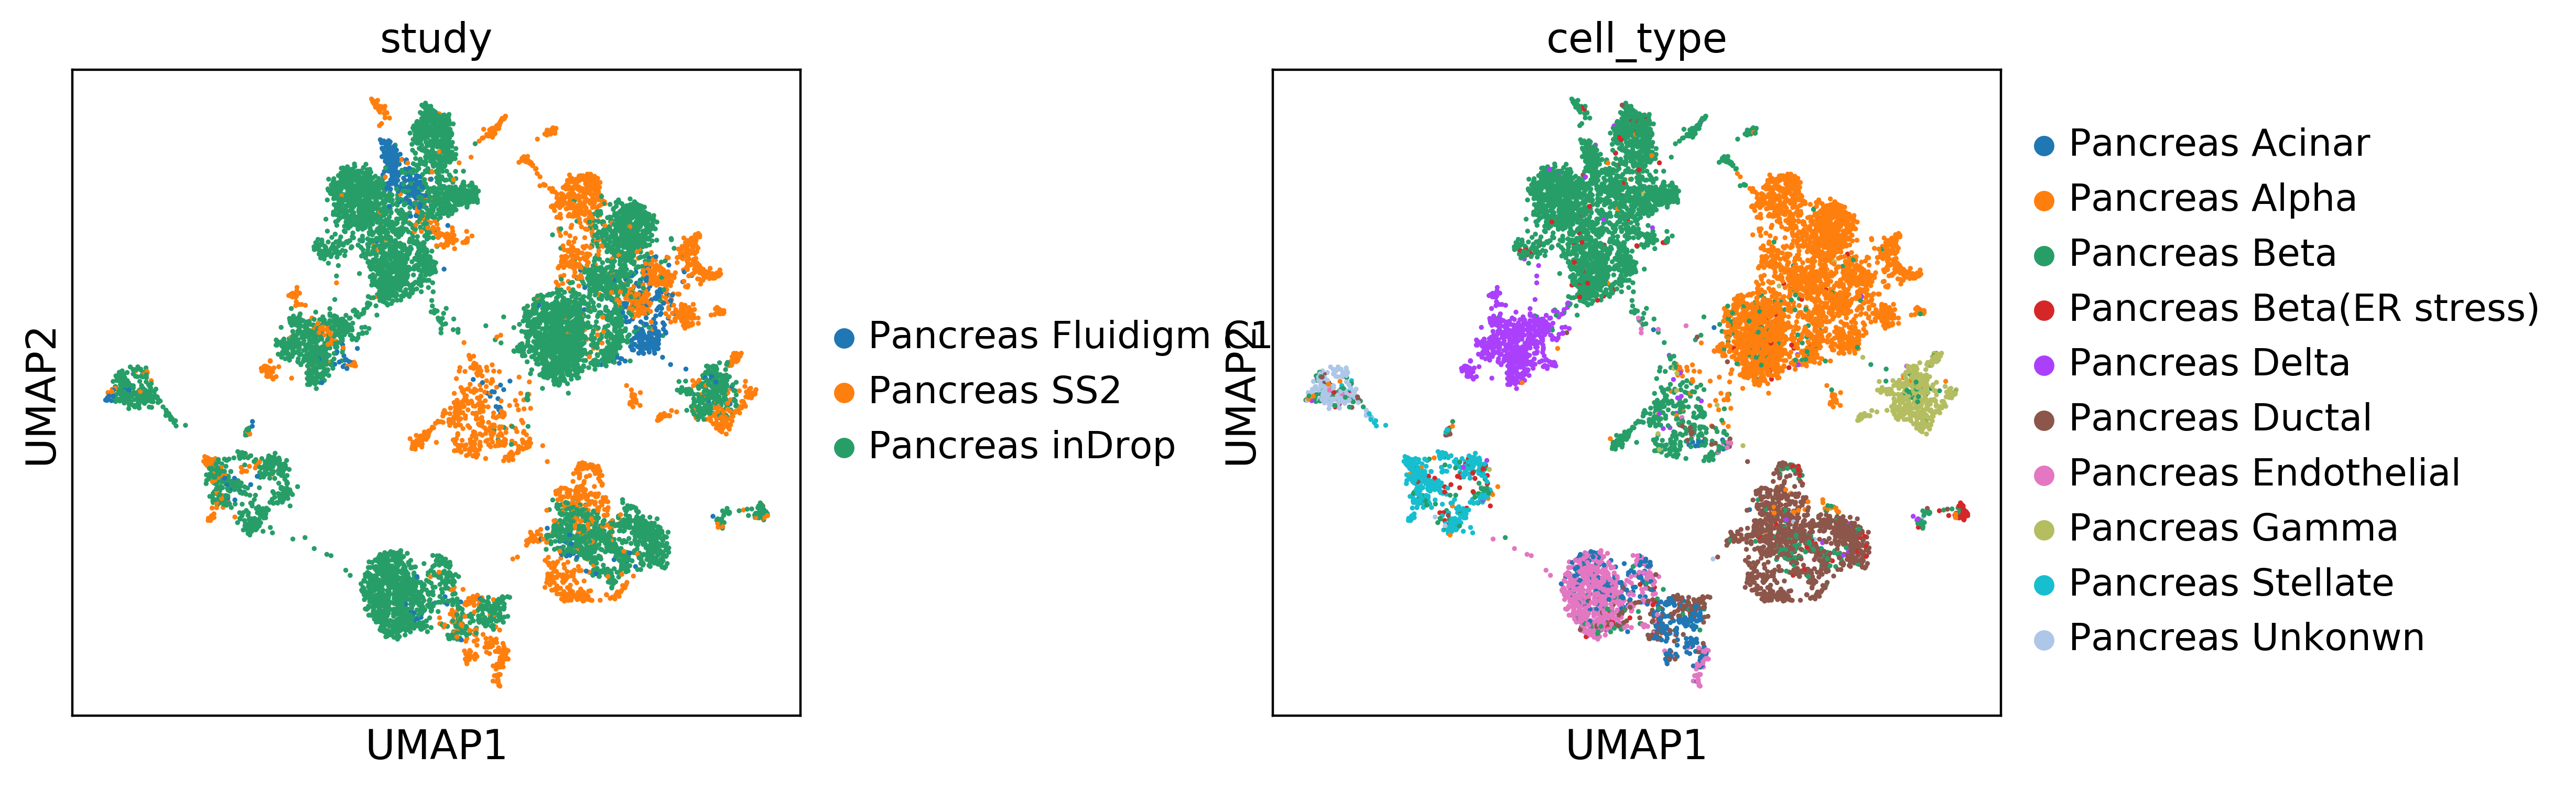

In [20]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5)